# NYC taxi tipping behavior visualization

## Introduction

This tutorial will introduce some basic methods for processing geo-related data, especially the data that can visualize urban mobility. Geo-related data can be an assistive tool to analyze human activity on the urban scale. 

A city can be measured in many perspectives. Through the data that recording by taxi in the city, we can get measurements across a large portion of landscapes without an embedded expensive sensor in the city infrastructure. Through NYC taxi open data, we can visualize human mobile behavior and how this behavior correlates with location, time, and event. NYC taxi open data recorded the pick-up and drop-off location, timing, distance, fare amount, tip…etc. Amount all the data, the tip amount is a feature that is highly influenced by passengers' cultural background. Where will people tip more when they get off the TAXI? Where can pick up the client that willing to tip more? Is tipping behavior related to the location? Can we see the gentrification through the taxi dataset?


## Tutorial content

In this tutorial, we will show how to do data visualization tools in Python, specifically using matplotlib to analysis the data and geopandas to map the data on shape file.

We’ll be using data from [NYC Yellow Taxi Trip Records](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). It is a huge dataset, so this tutorial only using 2019 June first as an example to show the data visualization pipeline.

## Installing the libraries
Before getting started, you'll need to install the geopandas libraries. 
```python
pip install geopandas
pip install matplotlib
```


In [1]:
import csv, sqlite3 
import pandas as pd 
from datetime import date
import json
import math
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely
from descartes import PolygonPatch

## Loading data and plotting


you can download the shape file or geojson file form here : https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
Let's load shpae file with geopandas!

In [2]:
zones = gpd.read_file('NYC_geo.shp').to_crs({'init' :'epsg:4326'})
zones['zone'] = zones.zone.astype('category')
zones['borough'] = zones.borough.astype('category')

you can plot with matplotlib to see what NYC shape file looks like

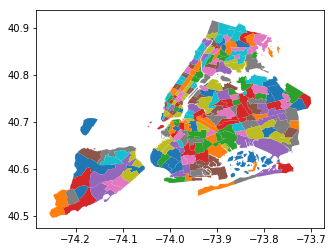

In [3]:
#Plot shpae file with matplotlib
%matplotlib inline
zones.plot(column='location_i', categorical=True)

after loading the geo data, let's load taxi data into pandas dataframe. The data is quite big, so we filter out 2019 June 1 to do the demo

In [5]:
#load csv file
csv_file = 'yellow_tripdata_2019-06.csv'
#single out 0601 for demo
df = pd.read_csv(csv_file, low_memory=False)
df['tpep_pickup_datetime'] = pd.DatetimeIndex(df['tpep_pickup_datetime'])
df = df.set_index('tpep_pickup_datetime')
date_from = pd.Timestamp('2019-06-01 00:00:00')
date_to = pd.Timestamp('2019-06-01 23:59:59')
df = df[(df.index > date_from ) & (df.index < date_to)]
df.to_csv('0601.csv')

# Data analysis with graph
Before we map the data with shape file, we can analysize teh data with matplotlib first!

In [16]:
df = pd.read_csv('0601.csv', low_memory=False)
df['tpep_pickup_datetime'] = pd.DatetimeIndex(df['tpep_pickup_datetime'])
df = df.sort_values(by=['tpep_pickup_datetime'])
df = df.set_index('tpep_pickup_datetime')
#caculated tipping_rate in NYC
df['tip_rate'] = round(df['tip_amount'].div(df['fare_amount']),2)
df = df.dropna()

We can see the general tipping behavior during a day:

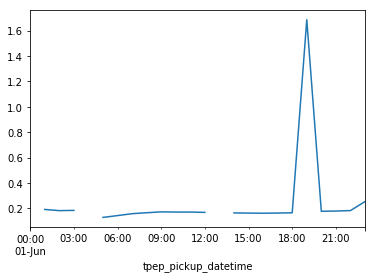

In [14]:
#tip in general
df = df.groupby(pd.Grouper(level=0, freq='H'))
df.head(10)
df_tip = df['tip_rate'].agg("mean")
df_tip.plot()

Tipping rate when drop off the client at airport:

tpep_pickup_datetime
2019-06-01 00:00:00    0.213131
2019-06-01 01:00:00    0.234019
2019-06-01 02:00:00    0.230978
2019-06-01 03:00:00    0.234261
2019-06-01 04:00:00    0.162857
2019-06-01 05:00:00    0.098261
2019-06-01 06:00:00    0.135556
2019-06-01 07:00:00    0.191299
2019-06-01 08:00:00    0.179589
2019-06-01 09:00:00    0.163030
2019-06-01 10:00:00    0.176923
2019-06-01 11:00:00    0.192632
2019-06-01 12:00:00    0.171886
2019-06-01 13:00:00    0.198081
2019-06-01 14:00:00    0.177175
2019-06-01 15:00:00    0.198146
2019-06-01 16:00:00    0.174490
2019-06-01 17:00:00    0.172718
2019-06-01 18:00:00    0.195116
2019-06-01 19:00:00    0.206300
2019-06-01 20:00:00    0.197654
2019-06-01 21:00:00    0.201677
2019-06-01 22:00:00    0.226971
2019-06-01 23:00:00    0.215803
Freq: H, Name: tip_rate, dtype: float64


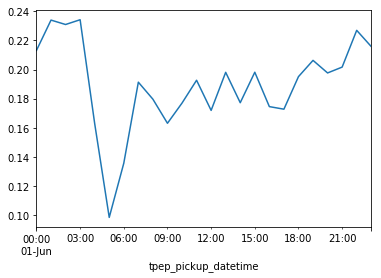

In [18]:
#tip in time square
df_tmsqr = df.loc[df['DOLocationID'] == 137]
df_tmsqr = df_tmsqr.groupby(pd.Grouper(level=0, freq='H'))
df_tmsqr_tip = df_tmsqr['tip_rate'].agg("mean")
print(df_tmsqr_tip)
df_tmsqr_tip.plot()



Tipping behavior from time square to airport:

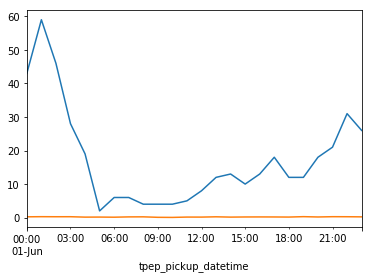

In [197]:
#tip 99 - 137 
df_tm_to_ap = (df.loc[(df.DOLocationID == 137) & (df.PULocationID == 79)])
df_tm_to_ap = df_tm_to_ap.groupby(pd.Grouper(level=0, freq='H'))
df_tm_to_ap_num = df_tm_to_ap.agg("size")
df_tm_to_ap_num.plot()
df_tm_to_ap_tip = df_tm_to_ap['tip_rate'].agg("mean")
df_tm_to_ap_tip.plot()

Ok! Now we can prepare the dataframe that we want to map on the shape file. Since the data might have some error, for example: tipping 5 times more than the fare, we need to clean those data.

In [283]:
#load 0601 data
df= pd.read_csv('0601.csv', low_memory=False)
df['tip_rate'] = round(df['tip_amount'].div(df['fare_amount']),2)
df = df.dropna()
#create df :   - tip ratepick up location
df_PU_tip = df
df_PU_tip['tpep_pickup_datetime'] = pd.DatetimeIndex(df_PU_tip['tpep_pickup_datetime'])
df_PU_tip = df_PU_tip.set_index('tpep_pickup_datetime')
df_PU_tip = df_PU_tip.sort_values(by = ['PULocationID'])
#df_PU_tip = df_PU_tip.groupby([pd.Grouper(level=0, freq='H'),'PULocationID'])
df_PU_tip = df_PU_tip.groupby(['PULocationID'])
df_PU_tip = df_PU_tip['tip_rate'].agg("mean")
df_PU_tip = df_PU_tip.where(df_PU_tip<1,0.5)

# Mapping the data to shape file
merge the datafram that have tipping information and the geodataframe. it is prepare the data for polting choropleth maps

In [284]:
joined = gpd.GeoDataFrame(pd.merge(df_PU_tip.to_frame(), zones, left_on = 'PULocationID', right_on='location_i'))

Once we have all the data we need, we can use Bokeh to plot it out!

You can also plot the choropleth maps with matplotlib!

0      0.077222
1      0.000000
2      0.172419
3      0.000000
4      0.000000
         ...   
230    0.000000
231    0.049717
232    0.141282
233    0.186465
234    0.198730
Name: tip_rate, Length: 235, dtype: float64


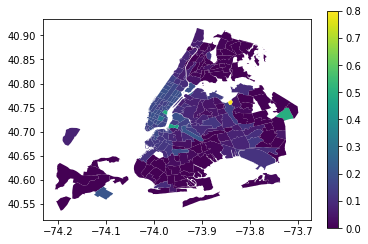

In [285]:
fig, ax = plt.subplots(1, 1)
joinedd = joined
print(joinedd['tip_rate'])
joinedd.plot(column='tip_rate', ax=ax, legend=True)


In the graph, we can see people tent to pay more when drop off at the airport!

Reference resource
<br>
[geopandas](https://pypi.org/project/geopandas/)
<br>
[geopandas mapping](http://geopandas.org/mapping.html)
<br>
[matplotlib](https://matplotlib.org/)



